### 漏洞分析与挖掘

#### 论文一：脆弱性推断：使用机器学习协助发现脆弱性

当前的主动化审计攻击，也都是仅限于已知程序模式的脆弱性检测。而这些技术也都是从模糊测试，污点分析和符号分析中衍生出来的，对于脆弱性的发现仍然需要依赖于人工审计，而这些都需要有专门的知识和能力。而这篇论文的主要贡献在于能够加速人工审计的速度，使用机器学习方法来协助发现源代码中的脆弱性问题。

对于脆弱性概念推断的概念，我们将面临两大问题：1. 我们如何自动捕获API中的可用模式；2. 我们如何才能将这些模式从已知脆弱性问题转移到其它代码段中。

这边主要是结合静态代码分析和机器学习技术。从以下四个步骤进行展开说明：

* 抽取API符号：抽取每个功能函数相关的函数名和其数据类型
* 嵌入到向量空间：将每个对应函数抽取到的API符号映射到向量空间中，这里我们使用TF-IDF。
* 识别API用法模式：使用PCA方法来找到最优的API用法模式
* 协助发现漏洞：对于每个函数得到的最优API用法模式作为已知脆弱性标准用于相似脆弱性的问题非发现

这里我们使用任何可识别的用于访问一个API的功能函数作为API符号，如函数的名称，数值类型和变量的类型。如下图：

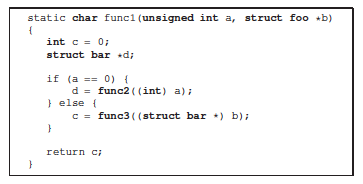

API的用法模式，它是关联到在多个函数的一系列的符号。如关系到lock函数，可能会关联到mutex_lock和mutex_unlock，而像字符类函数，会有strcpy, strcat和strlen等，我们通过频率来选择代码中的最优用法模式。

为了能够表示这个嵌入，从API符号到向量空间的映射，以下需要使用一些数学符号来表示。

定义$\mathcal{X}=\{x_1,\cdots,x_n\}$为源代码中的函数集合；$\mathcal{S}$为包含在$\mathcal{X}$中的所有符号的集合；映射关系如下：

$$\phi: \mathcal{X} \mapsto \mathbb{R}^{\mid \mathcal{S} \mid}, \phi(x) \mapsto (\phi_{\mathcal{s}}(x))_{\mathcal{s}∈{\mathcal{S}}}$$

其中，$\phi(x) := I(s,x) \cdot \text{TFIDF}(s)$，而$I$是指示函数：

$$I(s,x)=
\begin{cases}
1 & s ∈ x \\
0 & s ∉ x 
\end{cases}$$

将每个函数对应的向量存储成矩阵的形式：

$$M_{s,x}=\phi_s(x)$$

也就是这个矩阵$M$包含$\mid \mathcal{X} \mid$个列的向量，每个行向量包括$\mid \mathcal{S} \mid$个元素。

使用这种表示方法，必然会面的问题：1. 需要尽可能地找到所有的API符号；2. 矩阵中包含的元素个数会特别多，也是一个稀疏矩阵。

对于衡量函数的向量距离并不足以发现脆弱性，因为同一个API可能会在多个函数子集中被使用，当这个API存在问题时，我们不能仅仅说衡量函数的距离，而是需要找到一种用法模式能够匹配所有子集的组合。这就从局部单个，或多个函数的考虑迁移到全局，需要找到这个全局所存在的潜在语义，由此，我们就想到了使用PCA，PCA中的SVD分解，会得到相关的特征向量和特征值，而这些特征值我们可认为就是潜在的语义特征，它不依赖于单个，或多个API符号，而是抽象出来的全局语义特征。

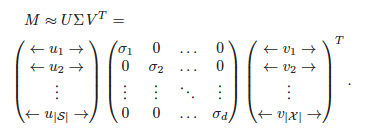

下面是这三个矩阵与函数符号和模式之间的相关性解释：

* 矩阵$U$是分解出的$d$个可能的用法模式
* 矩阵$\Sigma$中的对角元素值按照从大到小排序，表示的$U$中每个用法模式的重要程度
* 矩阵$V$与矩阵$U$具有相似的功能，主要还是适合于衡量函数的相似性

这种基于PCA的分解方法，对我们有如下的帮助：

* 脆弱性推断：通过计算矩阵$V$中的行向量来得到具有相似API用法模式的函数；在给定包含已知漏洞的函数，可以据此快速找到代码中与该漏洞相关的函数。
* 抽取最优用法模式：矩阵$U$的列向量是$d$个最佳API使用模式的表示，我们可以任意组合其中几个来作为重点关注，如特别是安全类函数，如网络和身份认证相关的函数。
* API浏览：通过比较矩阵$V$的行和矩阵$U$的列，分析出哪些APIs是值得关注的，哪些和哪些是具有相似的模式等。

计算函数向量的相似度，我们可以认为因函数向量其内部元素都是由各个功能函数组成，如果两向量具有很高的相似度，固然其这两个函数所具有的功能也应该是一样的，如果其中某个存在漏洞，那另外一个，或几个也应该存在，通过这样的方法我们可以加速代码审计的速度。

#### 论文二：从源代码中发现漏掉的漏洞

许多的漏洞都是因为对输入校验不足，而后又忽略或者是漏检了，而导致被恶意份子钻了空子。

莱斯定理指出用一个程序检测另一个程序是否包含漏洞，一般情况下那是不可判定的。但是我们可以挖掘指定类型的漏洞，如strcpy和strcat。一般的我们采用模糊测试、污点分析和符号执行都可以发现漏洞。大多数还是得靠人工审计，费时又费力。

大部分情况由于基于人工代码审计的工作量巨大，有很多可能会被忽略掉，这些忽略掉的部分也有可能是隐匿漏洞的地方。

Chucky - 做出的如下贡献：

* 缺少检测的识别：自动识别因缺少检测而发现的漏洞
* 条件异常检测：在自身条件下的缺检和不寻常的表达都可以被自动识别
* 自上而下和自下而上的分析：自上而下找不不受信任的输入和自下而上的访问控制点
* 相关性建议：高亮缺检和正常之间不同，并给出修复性建议

很多重要类型的漏洞都是由于缺少不要的安全检测，比如缺少用户访问权限控制，亦或是缓冲/整数型溢出。

如果能够认识到用户输入的数据是经过程序的各个过程的处理，最终流入数据库，所以在这个过程中就有一个自上而下的安全检测，以及确保安全地使用API：

* 检查实现的安全逻辑：web应用实施访问控制；操作系统限制资源访问；各种输入和变量都需要验证
* 检查确保安全的使用API：使用正确的API函数来配合检测输入/输出数据

Chucky正是基于数据源的输入，以及流经的API函数，都需要进行安全验证，如果能够找到基于这种观察的模式，就能够用其来发现潜在的威胁。比如这个数据在经过某个函数时，没有相关的安全校验，就认为其存在威胁。

在源代码中找到漏检有两大主要挑战：

1. 利用分散在代码中的信息来自动检查
2. 任何与这些检查对象相关的都需要被检出，并能够呈现给分析师

5个步骤用于识别缺失的检测：

* 健壮的解析：条件判断，赋值语句，API符号从函数源码中抽取出来送入解析器中，对于每个数据源的输入以下四个步骤都是独立进行的
* 邻居发现：具有相同输入数据的上下文关联
* 轻量级污点分析：针对每个函数中的每个数据源都独立进行自上而下，自下而上的检测
* 函数的嵌入：对于选择的函数和其相关的邻居使用污点分析条件嵌入到向量空间中
* 异常检测：通过计算与正规模型的距离来检测异常，需要提取检查过的函数和未检查过的函数之间存在的不同特征

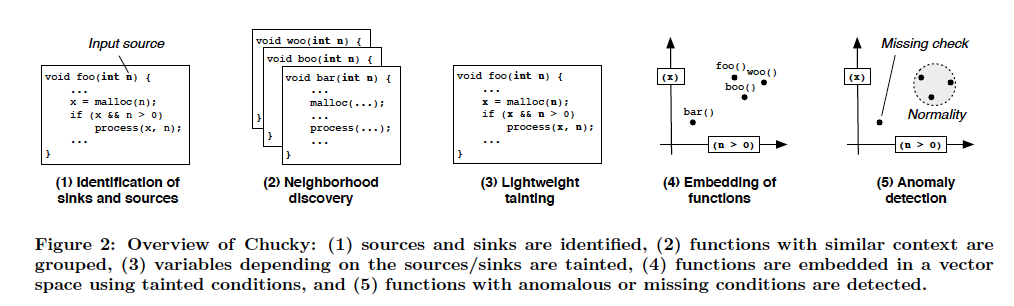

健壮的解析器：

* 主要用于对C/C++基于抽象语法树的解析
* 抽取的函数信息主要包括：
    * 数据源和污点：所有的函数参数，函数调用，包括全局和本地变量
    * API符号：提取API符号作为邻居发现的先决条件，参数和本地变量声明中使用的所有类型以及调用的所有函数的名称都被视为API符号
    * 赋值：描述变量间的信息流，通过执行污点分析来决定与接收变量相关的条件
    * 条件判断：存储所有的条件语句作为引用，如if, for, while
    
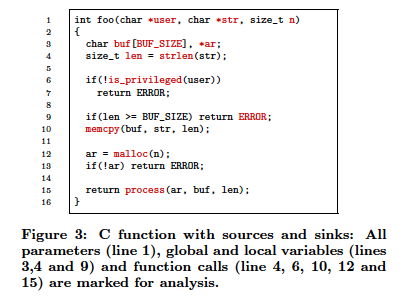
    
邻居发现：

因安全检测都会关联到上下文的函数，也是说我们需要找到所有与输入数据相关的函数，我们可以通过比较函数间相似性来找到。这里我们使用API符号，包括各参数类型和各功能函数的名称。这些特征能够标准一个函数类所具有的功能，如果两个或多个函数包括相似的这些特征，故可认为函数存在相似性。

要表示这些函数的相似性，这里使用自然语言处理中的词袋模型，来将之前收集的每个函数的API符号映射到向量空间中，相似的点，固然其在向量空间中靠的更近。

定义如下，所有的函数集$X={x_1,\cdots,x_m}$有如下映射：

$$\phi: X \mapsto \mathbb{R}^{\mid A \mid}, \phi(x) \mapsto (I(x, a) \cdot \text{TFIDF}(x, a, X))_{a∈A}$$

其中，$I$是指示函数

$$I(x,a)=\begin{cases}
1 & a \in x \\
0 & a \notin x
\end{cases}$$
    
我们提取所有函数的API符号代表的向量后，可以使用余弦距离来计算各向量间的相似度，进而找到相关的函数。但在此之前需要使用以下K近邻，将可能相关的进行一下聚合，然后找到跟输入源相关的函数进一步分析。参数$k$建议在10到30之间。

轻量级污点分析：

去掉与我们的输入数据非相关的集合，因为与输入数据相关的只有那么几个，即使是上述得到的相似的数据。我们通过建立有向无环图，将与输入数据源相关的数据操作进行关联，其节点为各个变量名和函数名，边反应的是两个之间的赋值关系。有向图开始于输入的数据源，中间经过所有与该数据相关的变量和函数，结束于函数的边界，这个边界就是从参数到函数作为结束，因为数据只在变量间传播。

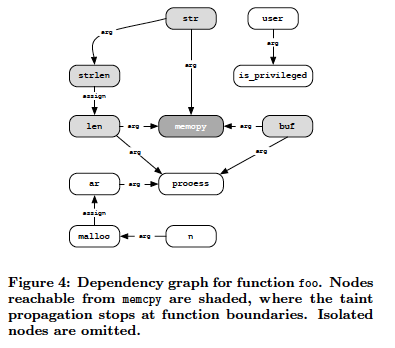

找到所有相关的标识符后，对于与这些标识符无关的条件即可删除，只关注相关的部分。

函数的嵌入

我们的目标是检测出一个函数中缺少安全检测的数据，而这个问题即可转化为单分类的异常检测。进一步我们就需要建模进行异常检测，那如何表示进行数值化表示一个函数中的这种关系就是重点！

在函数中跟数据源和污点相关的变量用$ARG代替，数值用$NUM代替，条件关系使用$CMP，函数返回值用$RET替代。同样使用基于词袋模型hash映射，将每个函数与数据源和污点相关的操作映射到向量空间中。注意这边选择的词袋模型的空间是前面找到与数据源和污点相关的所有函数和变量

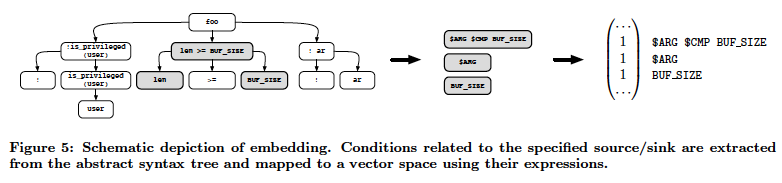

异常检测

在异常检测部分，我们自然而然需要有一个异常值能够给到分析师，对于每个函数的异常程度的度量，以及需要采取怎么的措施。自然我们能够想到的一种选择就是使用上述得到的向量的均值，再与该向量求差的最大范数，即是找到元素的最大差值。即为该函数的异常值。

$$f(x)=\|\mu-\phi(x)\|_∞=\max_{e∈E}(\mu_e-I(x,e))$$


补充知识：AST抽象语法树

ANTLR（全名：ANother Tool for Language Recognition）是基于LL(*)算法实现的语法解析器生成器（parser generator），用Java语言编写，使用自上而下（top-down）的递归下降LL剖析器方法。最早的ANTLR只支持Java, 直到ANTLR 3以后开始支持Ada95、C、C＃、JavaScript、Objective-C、Perl、Python、Ruby、C++和Standard ML。如同一般的词法分析器（lexer）和语法分析器（parser），ANTLR可以用来产生树状分析器（tree parsers）。

以上来自：https://zh.wikipedia.org/wiki/ANTLR

以下来自：https://zh.wikipedia.org/wiki/%E6%8A%BD%E8%B1%A1%E8%AA%9E%E6%B3%95%E6%A8%B9
https://juejin.im/post/5ab83f67f265da237e09b2f6
http://blog.chinaunix.net/uid-26750235-id-3139100.html

什么是抽象语法树？

在计算机科学中，抽象语法和抽象语法树其实是源代码的抽象语法结构的树状表现形式。

我们常用的浏览器就是通过将js代码转化为抽象语法树来进行下一步的分析等其他操作。所以将js转化为抽象语法树更利于程序的分析。

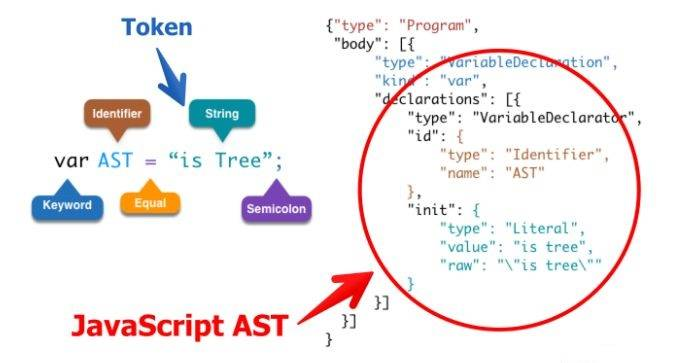

如上图中的变量声明语句，转化为AST之后就是右图的样子。

先来分析一下左图：

```
var 是一个关键字

AST是一个定义者

= 是Equal 等号的叫法有很多形式，在后面我们还会看到

“is tree” 是一个字符串

；就是 Semicoion
```

再来对应一下右图：

首先一段代码转化成的抽象语法树是一个对象，该对象会有一个顶级的type属性'Program',第二个属性是body是一个数组。

body数组中存放的每一项都是一个对象，里面包含了所有的对于该语句的描述信息：

```
type:描述该语句的类型 --变量声明语句
kind：变量声明的关键字 -- var
declaration: 声明的内容数组，里面的每一项也是一个对象
	type: 描述该语句的类型 
	id: 描述变量名称的对象
		type：定义
		name: 是变量的名字
    init: 初始化变量值的对象
		type: 类型
		value: 值 "is tree" 不带引号
		row: "\"is tree"\" 带引号
```

抽象语法树有哪些用途？

代码语法的检查，代码风格的检查，代码的格式化，代码的高亮，代码错误提示，代码自动补全等等

```
如：JSLint、JSHint 对代码错误或风格的检查，发现一些潜在的错误 IDE的错误提示，格式化，高亮，自动补全等等 代码的混淆压缩 如：UglifyJS2等
```

优化变更代码，改变代码结构达到想要的结构

```
代码打包工具webpack，rollup等等 CommonJS、AMD、CMD、UMD等代码规范之间的转化 CoffeeScript、TypeScript、JSX等转化为原生Javascript
```

通过什么工具或库来实现源码转化为抽象语法树？

那就是javascript Parser 解析器，他会把js源码转化为抽象的语法树。
浏览器会把js源码通过解析器转化为抽象语法树，再进一步转化为字节码或直接生成机器码
一般来说每一个js引擎都会有自己的抽象语法树格式，chrome的v8引擎，firefox的SpiderMonkey 引擎等等，MDN提供了详细SpiderMonkey AST format的详细说明，算是业界的标准。（SpiderMonkey是Mozilla项目的一部分，是一个用C语言实现的JavaScript脚本引擎，为了在SpiderMonkey中运行JavaScript代码，应用程序必须有三个要素：JSRuntime，JSContext和全局对象。）

常用的javascript Parser：

```
esprima
traceur
acorn
shift
```

我们主要拿esprima来举一个例子

安装：``` npm install esprima estraverse escodegen -S```

esprima 涉及三个库名称和功能如下：

esprima 把源码转化为抽象语法树

```
	let esprima = require('esprima'); // 引入esprima
	let jsOrigin = 'function eat(){};'; // 定义一个js源码
	
	let AST = esprima.parse(jsOrigin); // 通过esprima.parse将js源码转化为一个抽象语法树
	
	console.log(AST); // 打印生成的抽象语法树
   
	/*Script {
    type: 'Program',// 顶级的type属性
    body: [ FunctionDeclaration {
            type: 'FunctionDeclaration', // js源码的类型--是一个函数声明
            id: [Identifier],
            params: [],
            body: [BlockStatement],
            generator: false, // 是不是generator函数
            expression: false, // 是不是一个表达式
            async: false // 是不是一个异步函数
            },
            EmptyStatement { type: 'EmptyStatement' } 
          ],
    sourceType: 'script' 
    }*/
```

estraverse 遍历并更新抽象语法树

在介绍用法之前我们先来npm上看一下这个库,这个库的下载量居然500多万，而且没有README说明文档，是不是很牛掰！

在举例子之前我们要遍历抽象语法树，首先我们要先了解一下他的遍历顺序

```
	let estraverse = require('estraverse');
	

	estraverse.traverse(AST, {
	    enter(node){
	        console.log('enter', node.type)
	        if(node.type === 'Identifier') {
	            node.name += '_enter'
	        }
	    },
	    leave(node){
	        console.log('leave', node.type)
	        if(node.type === 'Identifier') {
	            node.name += '_leave'
	        }
	    }
	})
	
	// enter Program
	// enter FunctionDeclaration
	// enter Identifier
	// leave Identifier
	// enter BlockStatement
	// leave BlockStatement
	// leave FunctionDeclaration
	// enter EmptyStatement
	// leave EmptyStatement
	// leave Program
```

通过上面节点类型的打印结果我们不难看出，我们的抽象语法树的每个节点被访问了2次，一次是进入的时候，一次是离开的时候，我们可以通过下面的图来更加清楚的理解抽象语法树的遍历顺序

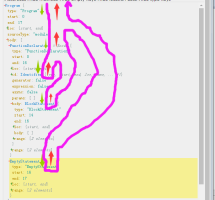
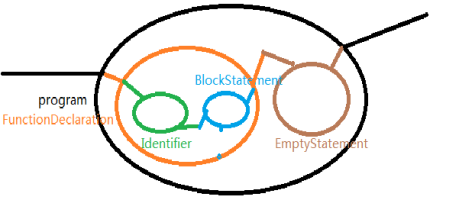

看完遍历顺序之后，我们看到代码中的判断条件 如果是变量名的话，第一次进入访问时对这个变量的名称做了一次修改，当离开的时候也做了一次修改。那接下来我们要验证 抽象语法树种的这个节点的变量名称 是否修改成功了呢？我们有两种方案，方案一：直接打印抽象语法树，这个非常简单再这里就你介绍了。方案二： 我们将现有的抽象语法树转化成源码看一下变量名是否变成功 这样就一目了然了。那怎么将我们的抽象语法树还原成源码呢？这就要引入我们的第三个库了 escodegen

escodegen 将抽象语法树还原成js源码

```
	let escodegen = require('escodegen');
	
	let originReback = escodegen.generate(AST);
	console.log(originReback);
    // function eat_enter_leave() {};
```

通过上面还原回来的源码我们看到变量名称确实被更改了。

接下来我们来探索一下如何用抽象语法树来将箭头函数转化为普通的函数

我们都知道es6语法转es5的语法我们用的是babel，让我们接下来就看一下 babel是如何将箭头函数转化为普通函数的。

第一步需要使用babel的两个插件，babel-core 核心模块 babel-types 类型模块

```
npm i babel-core babel-types -S
```

第一步：我们先来对比普通函数和箭头函数的抽象语法树，通过对比找出其中的不同之处，然后在节点可以复用的前提下，尽可能少的改变一下不同的地方，从而成功的将箭头函数转化为普通函数。

我们以这个箭头函数为例：

```
	let sum = (a,b) => a+b; 
	------>
	var sum = function sum(a, b) {
	  return a + b;
	};
```

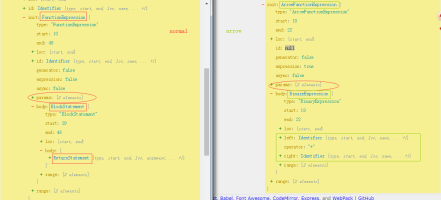

如上图所示，普通函数和箭头函数的AST的不同在于init，所以我们现在要做的是将箭头函数的arrowFunctionExpression 转换为FunctionExpression

利用babel-types生成新的部分的AST语法树，替换原有的。如果创建某个节点的语法树，那就在下面的网址上，需要哪个节点就搜哪个节点 babel-types

```
	// babel 核心库，用来实现核心的转换引擎
	const babel = require('babel-core');
	// 实现类型转化 生成AST节点
	const types = require('babel-types');
	let code = 'let sum = (a,b) => a+b;';
	let es5Code = function (a,b) {
	    return a+b;
	};
	
	// babel 转化采用的是访问者模式Visitor 对于某个对象或者一组对象，不同的访问者，产生的结果不同，执行操作也不同
	
	// 这个访问者可以对特定的类型的节点进行处理
	let visitor = {
	    ArrowFunctionExpression(path) {
	        // 如果这个节点是箭头函数的节点的话，我们在这里进行处理替换工作
	        // 1.复用params参数
	        let params = path.node.params;
	        let blockStatement = types.blockStatement([types.returnStatement(path.node.body)])
	        let func = types.functionExpression(null, params, blockStatement, false,false);
	        path.replaceWith(func)
	
	    }
	};
	
	let arrayPlugin = {visitor};
	
	// babel内部先把代码转化成AST,然后进行遍历
	
	let result = babel.transform(code, {
	    plugins: [
	        arrayPlugin
	    ]
	});
	
	console.log(result.code);
    // let sum = function (a, b) {
    //     return a + b;
    // };
```

我们写一个babel的预计算插件

```
	let code = `const result = 1000 * 60 * 60 * 24`;
	//let code = `const result = 1000 * 60`;
	let babel = require('babel-core');
	let types = require('babel-types');
	//预计算
	let visitor = {
	    BinaryExpression(path){
	        let node = path.node;
	        if(!isNaN(node.left.value)&&!isNaN(node.right.value)){
	            let result = eval(node.left.value+node.operator+node.right.value);
	            result =  types.numericLiteral(result);
	            path.replaceWith(result);
	            //如果此表达式的父亲也是一个表达式的话,需要递归计算
	            if(path.parentPath.node.type == 'BinaryExpression'){
	                visitor.BinaryExpression.call(null,path.parentPath);
	            }
	        }
	    }
	}
	let r = babel.transform(code,{
	    plugins:[
	        {visitor}
	    ]
	});
	console.log(r.code);
```

#### 论文三 软件漏洞检测综述

常见的用于漏洞检测的方法有：静态分析，模糊测试，污点分析，符号执行和混合测试。

相比入侵检测和防御，漏洞检测的重点是识别并最终纠正缺陷，而不是检测和阻止利用漏洞的攻击。

* 静态分析

静态分析是一种不需要运行程序进行源码（或二进制代码）分析的方法，因此，它可以避免恶意程序执行带来的风险。

与动态测试相比，静态分析的代码覆盖率更高，因此，它的漏报率就相对比较低，但使用相似模式匹配的方法，会带来的高误报率。支持的漏洞检测种类较多，一般静态分析会用在词法分析，数据流分析，抽象解释，模型检查。

    * 词法分析
    
    词法分析也叫做语法结构分析，或模式匹配或句法分析。Flawfinder, ITS4, PMD , RATS 和 Findbugs都是基于词法分析。词法分析将程序划分成一个个标记化的流，并搜索一组预先定义的易受攻击的函数或模式。比如，词法分析可以检测C语言中使用不安全函数带来的潜在威胁，像strcpy(), strcat()等。
    词法分析简单，而且速度也很快，但是缺点就是这个方法太简单，而使得会出现大量误报率，是因为这种方法会忽略程序中的数据流（也就是上下文关系，只是简单的匹配预先定义的不安全函数）。
    
    * 数据流分析
    
    数据流分析一般是编译器用来优化程序的。它使用一个控制流图来检测在各个程序点上可能的一组值。数据流分析也可应用在漏洞检测。Jlint, FindBUGS, Parfait都是基于数据流分析的工具。
    
    * 抽象解析
    
    抽象解释是由Patrick Cousot和RadhiaCousot在1978年提出的。抽象解释依赖于近似概念。有时也被称为语义近似理论。根据这一理论，一个变量在某个程序点上所能得到的所有可能值都可以用一个可表示的区间集合来近似。抽象解释中的近似概念是由Galois连接和用于确保循环系统终止的推断来定义的。Astree和Frama-C是基于抽象解释的攻击。
    
    * 模型检测
    
    模型检测是一种自动化技术，有助于检测属性对于给定状态的模型是否成立。通常，被标识为临时逻辑的公式的模型检查器的输入会被分析和检测，用以确定是否需要保留程序属性。在实践中，有时检查所有系统的状态时不可行，对于具有数百万loc和状态爆炸问题的商业软件来说，可能会出现这样的问题。CMMC, Java Pathfinder, SLAM, BLAST,都是基于模型检测的。

* 模糊测试

模糊测试是一种基于随机输入数据到程序中，直到程序崩溃的程序测试技术。是由威斯康星大学的Barton Miller 1990年提出的。

模糊测试的关键是数据生成，模糊测试根据数据生成方法，可被分类为随时模型测试，基于突变的模糊测试，基于生成的模糊测试和基于方向的模糊测试。

随机模糊测试时一种最简单的测试技术，一个完整的随机输入数据流会被发送到程序中用于测试。输入的数据可以是命令行选项，事件，或网络数据包。这种类型的模糊特别适用于测试程序如何对大型或无效的输入数据作出的反应。虽然随机模糊可以发现已被确认为严重的漏洞，现在对于模糊测试有一个更加详细的数据输入格式的理解，这也是程序测试所预期的。

基于突变的模糊测试又是另一种模糊测试方法，它需要被实测程序对输入数据格式有一定的了解。基于现有的数据样本，基于突变的模糊测试工具会生成新的辩题，基于启发式，都是用于模糊测试的。突变算法是提高模糊测试效率的关键。

基于生成的模糊测试会根据一定的规则生成程序输入。相比纯净的随机模糊测试，生成模糊测试会有通常在程序测试时会有更高的覆盖率，尤其更适合当输入的数据的格式相当复杂和有校验码的情况。

基于方向的模糊测试使用程序控制流来直到模糊测试，所以也称为测试用例生成模糊测试。SAGE就是一种基于方向的模糊测试。首先，它构造一个初始和有效的输入IN0，将输入发送到程序P，符号执行引擎在IN0上观察P的进程和一个以逻辑公式形式出现的路径约束；其次，它消除执行过程中遇到的路径约束，通过约束求解器解决新的约束，并创建一个执行路径不同于IN0的新输入IN1；最后，它在IN0中以IN1的方式进行处理，并重复前面的三个过程。

在模糊测试上有很多研究和工具，如Sully, SPIKE, Peach, Bestorm, Spider Pig等。在实践中，大型分布式系统的最新测试往往依赖于模糊测试。不幸的是，这种方法的缺点是，可能的输入空间非常大，效率很低。

* 污点分析

在污点分析期间，不管数据是否是恶意的，所有来自于未知的非信任的数据源的输入数据都被标记为污点，并跟踪监测是否污点输入数据会被用在汇聚点上，如一个API是将字符数据转换为执行代码的。当今比较常见的注入漏洞，是将用户输入的数据当做命令来动态执行了，常见的有SQL注入和跨站脚本，还有命令执行漏洞。污点分析有两种形式，动态和静态。

    * 动态污点分析
    
    在动态污染分析中使用的方法是将来自不可信输入的数据标记为污染。分析会持续跟踪所有内存中的污点数据，当这些数据在一个危险的情景下被使用，一个可能的bug就被检测到。这种方法提供了检测大多数输入验证漏洞的可能，而且误报率较低。然而我们也在使用动态污点分析时也会有一些缺点。程序的执行速度较慢，因为需要进行必要的附加检查，并且只检测到目前为止已执行的执行路径(而不是所有可执行路径)的问题，这可能导致漏报率。
    
    BitBlaze是一个动静结合的二进制分析平台，采用混淆和符号执行，系统模拟和二进制指令等技术。动态分析技术被BitBlaze用于检测重写攻击的检测。
    
    BuzzFuzz是一个自动白盒模糊测试攻击，不像标准的模糊测试工具，它使用动态污点跟踪技术自动锁定原始输入文件中在关键程序攻击点上有影响价值的数据的位置。新的输入文件是通过对已识别的污染区域进行模糊处理而生成的。因为它使用污染分析来自动发现和利用有关输入文件格式的信息，所以它特别适合测试具有复杂输入文件格式的程序。
    
    * 静态污点分析
    
    静态污染分析是用来检测受用户输入影响的指令集的过度近似的技术。这组受污染的指令只有通过分析程序的来源才能静态地计算出来。静态污染分析的主要优点是它考虑了程序的所有可能的执行路径。另一方面，分析可能不像动态执行的分析那样精确，因为静态分析器无法访问程序的附加运行时信息。
    
    Parfait是一个静态多层分析框架。在预处理阶段采用静态污染分析。Parfait使用的方法是将污染分析简化为一个图的可达性问题。
    
* 符号执行

符号执行是一种用于训练通过目标系统的各种代码路径的技术。符号执行引擎不使用具体的输入值来运行目标系统，而是用符号变量替换输入，这些变量最初允许为任何内容，然后运行目标系统。每当系统执行基于符号值的分支(依赖于符号输入)时，符号执行引擎就会分叉，跟踪每个分支并在分支节点中添加对符号变量的约束。